# Creating your first POPCON

Welcome to cfspopcon!

This notebook will work you through how to set up a POPCON run and plot the results.

To start with, execute the cell below to import some additional libraries that we'll frequently use, as well as the cfspopcon library itself. If you can execute this cell without error, that's a great start. If not, make sure that the cfspopcon library is installed correctly.

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import cfspopcon
from cfspopcon.unit_handling import ureg

# Change to the top-level directory. Required to find radas_dir in its default location.
%cd {Path(cfspopcon.__file__).parents[1]}
# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

/Users/tbody/Code/cfspopcon
Running in /Users/tbody/Code/cfspopcon


The simplest way to configure a POPCON analysis is via a configuration file. For this, we use YAML files (which map neatly to python dictionaries).

In the next cell, we read in the `SPARC_PRD/input.yaml` file, applying a few conversions on the data. This includes

1. The `algorithms` entry is converted into a `cfspopcon.CompositeAlgorithm` which we'll talk about later. This basically gives the list of operations that we want to perform on the input data. 
2. The `points` entry is stored in a separate dictionary. This gives a set of key-value pairs of 'optimal' points (for instance, giving the point with the maximum fusion power gain).
3. The `grids` entry is converted into an `xr.DataArray` storing a `np.linspace` or `np.logspace` of values which we scan over. We usually scan over `average_electron_density` and `average_electron_temp`, but there's nothing preventing you from scanning over other numerical input variables or having more than 2 dimensions which you scan over (n.b. this can get expensive!).
4. Each input variable is checked to see if its name matches one of the enumerators in `cfspopcon.named_options`. These are used to store switch values, such as `cfspopcon.named_options.ReactionType.DT` which indicates that we're interested in the DT fusion reaction.
5. Each input variable is converted into its default units, stored in `cfspopcon.unit_handling.default_units.DEFAULT_UNITS`. This will set, for instance, the `average_electron_temp` values to have units of `keV`.

In [2]:
input_parameters, algorithm, points, plots  = cfspopcon.read_case("example_cases/SPARC_PRD")

We first want to make sure that our analysis won't crash due to missing input variables. For this, we use the `validate_inputs` method of the `cfspopcon.CompositeAlgorithm` object, which makes sure that all required input variables are defined by the `input.yaml` file. It will also tell you if the algorithms you're requesting are out of order.

In [3]:
algorithm.validate_inputs(input_parameters);

Since we're looking at the example, it's unsurprisingly well behaved. Let's intentionally drop an input variable to show that it works.

In [4]:
incomplete_input_parameters = input_parameters.copy()
del incomplete_input_parameters["major_radius"]

algorithm.validate_inputs(incomplete_input_parameters, raise_error_on_missing_inputs=False);

/var/folders/vd/h84xj6nn6njb0ln3bvd_48p80000gq/T/ipykernel_99100/170706882.py:4: UserWarning: Missing input parameters [major_radius].
  algorithm.validate_inputs(incomplete_input_parameters, raise_error_on_missing_inputs=False);


Next, we pack all of the (complete) input parameters into an `xarray.Dataset`.

If you're not familiar with `xarray`, a `Dataset` functions like a dictionary which stores labelled `xr.DataArray`s, which in turn function like `np.array`s but with additional annotation to describe the coordinates and units of the array. We'll use a lot of `xarray` features, so it's worth [reading the docs](https://docs.xarray.dev/en/stable/), including their useful [How do I ...](https://docs.xarray.dev/en/stable/howdoi.html) section.

Our starting dataset isn't super interesting: it's exactly what we defined in the `input.yaml` file. In the next cell, we construct a dataset from out input parameters, and then print into the notebook a representation of the notebook (this is the somewhat odd-looking second line).

In [5]:
dataset = xr.Dataset(input_parameters)

dataset

Magnitude,[0.06 0.0031 1.5e-05]
Units,dimensionless
Magnitude,[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0]
Units,_1e19_per_cubic_metre
Magnitude,[5.0 5.517241379310345 6.0344827586206895 6.551724137931035 7.068965517241379 7.586206896551724 8.10344827586207 8.620689655172415 9.137931034482758 9.655172413793103 10.172413793103448 10.689655172413794 11.206896551724139 11.724137931034484 12.24137931034483 12.758620689655173 13.275862068965518 13.793103448275863 14.310344827586208 14.827586206896552 15.344827586206897 15.862068965517242 16.379310344827587 16.896551724137932 17.413793103448278 17.93103448275862 18.448275862068968 18.96551724137931 19.48275862068966 20.0]
Units,kiloelectron_volt


Let's run a POPCON!

We'll use the `update_dataset` method of our algorithm and pass in our dataset of input parameters.

The `CompositeAlgorithm` calls the `update_dataset` for each of its `Algorithm`s. These calls check that all of the required inputs are defined in the dataset, and then write the results back into the dataset.

In [6]:
dataset = algorithm.update_dataset(dataset)

dataset

Magnitude,[[6.70892512810257 6.708924886566515 6.708924756230591 ... 6.7089229312816405 6.708922892283584 6.708922853121795] [7.762498163093323 7.762497607889943 7.762497255303387 ... 7.7624943484464755 7.762494287429691 7.762494226645695] [8.862680091166432 8.862679208048771 8.862678607243824 ... 8.862674232587405 8.862674152699649 8.862674073515919] ... [48.60784721913763 48.6076617407665 48.60755101190802 ... 48.60683828957817 48.60683095876299 48.6068238146231] [50.59849721857003 50.598278669230304 50.598148393559136 ... 50.59730919498176 50.597300545907 50.5972921170256] [52.61497096786498 52.61471700451897 52.61456580589732 ... 52.6135912050144 52.613581144069485 52.6135713392212]]
Units,second
Magnitude,[[64654.342481970416 123203.67027736278 179398.2800155604 ... 1799272.0278467364 1840639.9595082228 1881815.4716755108] [72272.56854601632 137799.4162937412 200718.74520752116 ... 2014248.7885306939 2060475.0679165947 2106479.7807919597] [79972.09950168266 152556.0571067695 222277.9689673043 ... 2231098.73018068 2282198.8747847117 2333046.5733841555] ... [288403.7780307916 552795.56084644 807398.8553966347 ... 7862230.169905341 8029716.933132806 8195616.021197384] [297159.9248605935 569620.3547788296 831992.7030921815 ... 8087552.944554527 8259257.873748582 8429299.18874531] [305938.84180339327 586488.9564434903 856649.6633598846 ... 8312522.759189555 8488402.77357654 8662541.501783252]]
Units,pascal
Magnitude,[[83.60490186516306 75.09902396456609 68.0987786469571 ... 19.276703581978595 18.708871545213334 18.17179888010542] [85.04938284584509 76.44322875869452 69.35475291882562 ... 19.73275326263532 19.152992279698502 18.604554869939225] [85.77792512464491 77.1259299027328 69.99606608390096 ... 19.967774983986555 19.38163480555066 18.827113076451337] ... [86.04505161279359 77.42210172218154 70.2893599097392 ... 19.45464830625189 18.849828318344105 18.27744139994259] [85.96987281418713 77.35132054453187 70.22193316081372 ... 19.404716725363826 18.80007894107419 18.227866790237208] [85.89375367128144 77.27960452690213 70.15358467497103 ... 19.35424203933357 18.74979517938415 18.177766190690683]]
Units,_1e20_per_cubic_metre kiloelectron_volt second
Magnitude,[0.0016368206709051207 0.0017194006682208739 0.0017981922608704794 0.0018736734390577738 0.0019462294071888554 0.0020161759979185306 0.002083775996540627 0.002149250835276092 0.0022127891680210027 0.002274553286095355 0.00233468400441329 0.002393304441486577 0.0024505229847555958 0.0025064356460901952 0.0025611279540795444 0.002614676489805913 0.002667150144914956 0.0027186111609967265 0.002769115995019362 0.00281871604512554 0.0028674582633796543 0.002915385676270014 0.0029625378293916286 0.0030089511693865297 0.003054659373633771 0.0030996936361687034 0.003144082916731182 0.003187854158592729 0.003231032479817103 0.0032736413418102414]
Units,dimensionless
Magnitude,[[0.003322598490594971 0.002749055632946764 0.0023139898721289114 ... 0.00025336000993611503 0.00024048201502327386 0.00022857182789826611] [0.006513914212832544 0.005390096682141376 0.004537519203422363 ... 0.0004974181746895646 0.0004721477950463949 0.00044877588636308194] [0.009655678052190978 0.007990368319558782 0.0067269048202420806 ... 0.0007379654006136056 0.0007004859229778813 0.0006658215597768279] ... [0.11316846972571139 0.093693920241988 0.07891174536009812 ... 0.008700178930903581 0.008259234866782261 0.007851363861700005] [0.11605065205199189 0.09608061776998052 0.08092226594198702 ... 0.008922333439341597 0.008470140435777762 0.008051863692488984] [0.11893040592543976 0.09846531725792948 0.08293111319431577 ... 0.009144315874310563 0.008680882913738084 0.008252208727618802]]
Units,dimensionless
Magnitude,[[1.0 1.0 1.0 ... 0.8965407130965133 0.8738828079668282 0.852576365382913] [1.0 1.0 1.0 ... 0.3577328772982827 0.3489160538938257 0.3406548842419241] [1.0 1.0 1.0 ... 0.21121433123123184 0.20585103430907478 0.20084742304711234] ... [1.0 0.8917955805348375 0.6668569024664809 ... 0.02522458970

# Plotting and interrogating the results

That's it: the only thing left is to look at our results. We can use the built-in plotting functionality, which is configured by dictionaries which we read in from YAML files using `read_plot_style`.

Nothing fancy is happening here: it's just reading in a dictionary from a file and not doing any conversions. You can modify the YAML file, or directly make a dictionary yourself. The structure of the dictionary is

* `type`: what sort of plot do you want to make. Currently we only support `popcon`, but room for growth.
* `figsize`: the size of the figure in inches, defining both the aspect ratio and text size of the resulting plot. If you want larger overall labels, try reducing `figsize`
* `show_dpi`: the pixels-per-inch of the resulting figure. Increase this if your figure is blurry. This will also make the figure larger in the Jupyter notebook.
* `save_as`: a name for the figure when saving it as a `.png`
* `coords` or `new_coords`: what to use as the x-axis and y-axis. `coords` must be already in the coordinates of the dataset, while `new_coords` can be output variables (see the example below)
* `fill`: a block for a variable to be plotted as a colormesh. Inside this, we define a section `where` which we use to build a mask (discussed below)
* `points`: a block for points to be highlighted on the plot. These must correspond to points defined in the `input.yaml` file
* `contour`: a block for variables which we should plot contours for. We pick a single color per contour and then label the contour lines themselves at specific values, which lets us show multiple variables at once


In [7]:
plot_style = cfspopcon.read_plot_style("example_cases/SPARC_PRD/plot_popcon.yaml")

plot_style

{'type': 'popcon',
 'figsize': [8, 6],
 'show_dpi': 150,
 'coords': {'x': {'dimension': 'average_electron_temp',
   'label': '$<T_e>$ [$keV$]',
   'units': 'keV'},
  'y': {'dimension': 'average_electron_density',
   'label': '$<n_e>$ [$10^{20} m^{-3}$]',
   'units': 'n20'}},
 'fill': {'variable': 'Q',
  'where': {'Q': {'min': 1.0},
   'P_auxillary': {'min': 0.0, 'max': 25.0, 'units': 'MW'},
   'greenwald_fraction': {'max': 0.9},
   'ratio_of_P_SOL_to_P_LH': {'min': 1.0},
   'max_flattop_duration': {'min': 0.0, 'units': 'seconds'}}},
 'points': {'PRD': {'label': 'PRD',
   'marker': 'x',
   'color': 'red',
   'size': 50.0}},
 'contour': {'Q': {'label': '$Q$',
   'levels': [0.1, 1.0, 2.0, 5.0, 10.0, 50.0],
   'color': 'tab:red',
   'format': '1.2g'},
  'ratio_of_P_SOL_to_P_LH': {'label': '$P_{SOL}/P_{LH}$',
   'color': 'tab:blue',
   'levels': [1.0],
   'format': '1.2g'},
  'P_auxillary': {'label': '$P_{aux}$',
   'levels': [1.0, 5.0, 10.0, 25.0, 50.0],
   'color': 'tab:gray',
   'format'

Once we have our `plot_style`, we call `cfspopcon.plotting.make_plot` to make a figure.

N.b. we've set `output_dir=None` to stop `make_plot` from saving the figure to a `.png` file. If you're using the command-line tool, you can delete the `save_as` key in `plot_style`.

It's pretty easy to make this plot, but not entirely straightforward to interpret it.

Firstly, the axes are for the average density and for the average temperature. These are more often the outputs of a calculation, rather than the independent variables. This is a consequence of the particular 'back to front' algorithm that we're using, which uses the average temperature and density to define the plasma stored energy and the resulting confinement time and input power required to stay at that point.

Next, it's helpful to remember that all of the points shown are completely independent. Each represents a time-independent solution of the given algorithm.

Although we get a solution at all $(\bar n_e, \bar T_e)$ points, they don't all make sense as operational points. There are a set of limits that we impose via the `where` block inside the `fill` block. For this example, these are

1. We're looking for high fusion gains, with at least $Q>1$,
2. Since we're using the ITER98y2 H-mode energy confinement scaling, we require that $P_{SOL} > P_{LH}$,
3. We can't switch off the Ohmic power, so we neglect points with $P_{RF} <= 0$,
4. To avoid density-limit disruptions, we require that the volume-averaged density is no more than 90% of the Greenwald density limit,
5. To avoid damaging the magnets with neutrons, we impose a limit of $P_{fusion} < 140MW$.

We mask points which don't meet these requirements, and then plot a variable over the unmasked region (in this case, we're plotting $Q$).

On top of this, we plot contours of fields of interest such as the divertor heat-flux metric $P_{SOL} B_{pol} / R n^2$ so we can see the trends of these field as we go across the accessible parameter space.

Finally, within the accessible parameter, we select points which minimize or maximize the values of fields, such as the point giving the maximum value of $Q$.


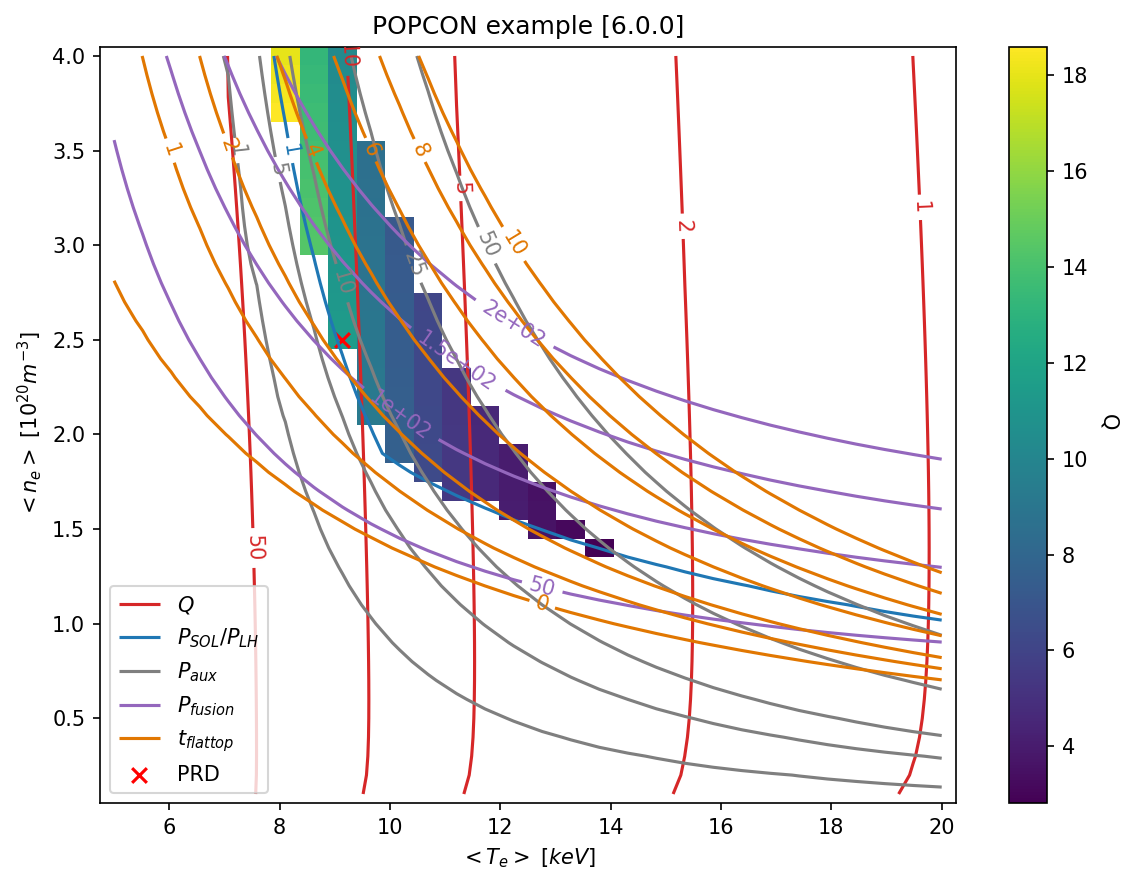

In [8]:
cfspopcon.plotting.make_plot(
    dataset,
    plot_style,
    points=points,
    title="POPCON example",
    save_name=None
)

There's lots of functionality which you can explore (and extend!). For example, if you'd prefer to look at the results in terms of the auxillary heating power instead of the average electron temperature, you can use `cfspopcon.transform` to map the results onto new axes.

Some of these features are a bit experimental. For instance, you can see here that by remapping we've shrunk the range of $Q$ in the accessible parameter space, since we apply a transformation on the masked array. Increasing the resolution of the analysis grid should reduce the difference when remapping.

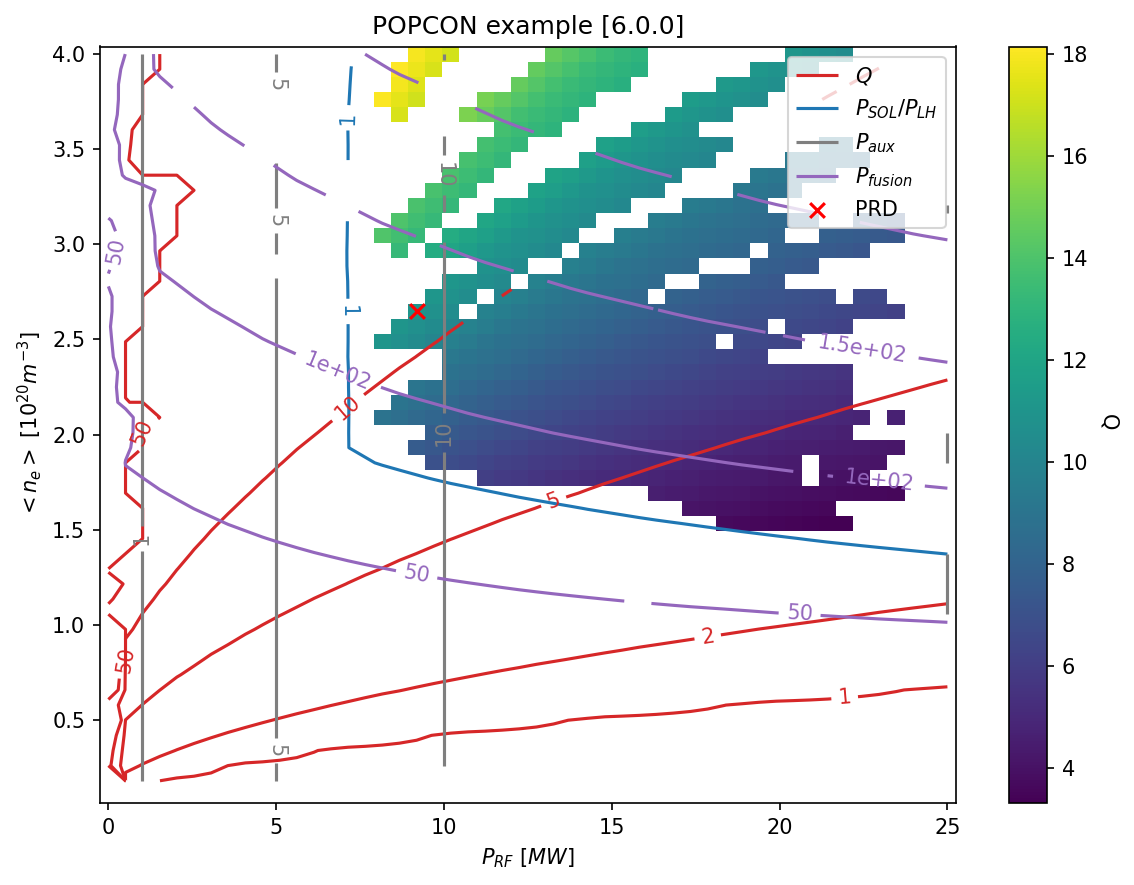

In [9]:
cfspopcon.plotting.make_plot(dataset,
                             cfspopcon.read_plot_style("example_cases/SPARC_PRD/plot_remapped.yaml"),
                             points=points,
                             title="POPCON example",
                             save_name=None,
                            )

We often want to study individual points in detail.

The simplest way to do this is to use `file_io.write_point_to_file` which writes the values at the points specified in the `points` dictionary to a JSON file.

In [10]:
for point, point_params in points.items():
    cfspopcon.file_io.write_point_to_file(dataset, point, point_params, output_dir=Path("example_cases/SPARC_PRD/output"))

You can dig into the output file `SPARC_PRD/outputs/max_Q.json`, or alternatively we can peek under the hood to understand what is going on. Let's pick the `max_Q` point which we defined in `input.yaml`.

In [11]:
point_params = points["PRD"]

point_params

{'maximize': 'Q',
 'where': {'P_auxillary': {'min': 0.0, 'max': 25.0, 'units': 'MW'},
  'greenwald_fraction': {'max': 0.9},
  'ratio_of_P_SOL_to_P_LH': {'min': 1.0},
  'P_fusion': {'max': 140.0, 'units': 'MW'}}}

We first build a *mask* from the `where` key. This lets us hide parts of operational space which aren't physical (for example, if they have $P_{SOL}$ below the LH transition).

This can be used with the `where` method of an `xarray.DataArray`.

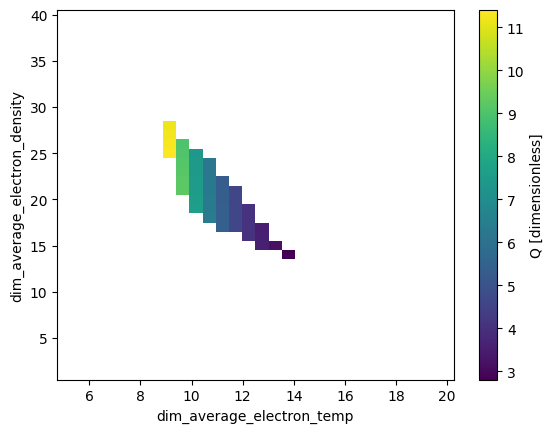

In [12]:
mask = cfspopcon.shaping_and_selection.build_mask_from_dict(dataset, point_params)

dataset.Q.where(mask).plot()

Next, let's find the point here with the highest value of Q. This gives us the indices of the corresponding point.

In [13]:
point_indices = cfspopcon.shaping_and_selection.find_coords_of_maximum(dataset.Q, mask=mask)

point_indices

{'dim_average_electron_density': <xarray.DataArray 'Q' ()> Size: 8B
 array(24),
 'dim_average_electron_temp': <xarray.DataArray 'Q' ()> Size: 8B
 array(8)}

We can use those indices to select a point of the array, see the coordinates and value at that point.

In [14]:
dataset.Q.isel(point_indices)

<xarray.DataArray 'Q' ()> Size: 8B
<Quantity(11.40073536510645, 'dimensionless')>
Coordinates:
    dim_average_electron_temp     float64 8B 9.138
    dim_average_electron_density  float64 8B 25.0

We can also select this point for all of the variables defined in our dataset, which lets us look at the values of *all* of the different fields at that point (you might need to click the arrow next to "data variables" to see these).

In [15]:
point = dataset.isel(point_indices)

point

Magnitude,[0.06 0.0031 0.01687905506268707 1.5e-05]
Units,dimensionless
Magnitude,[0.0 0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 0.2 0.22 0.24 0.26 0.28 0.3 0.32 0.34 0.36 0.38 0.4 0.42 0.44 0.46 0.48 0.5 0.52 0.54 0.56 0.58 0.6 0.62 0.64 0.66 0.68 0.7000000000000001 0.72 0.74 0.76 0.78 0.8 0.8200000000000001 0.84 0.86 0.88 0.9 0.92 0.9400000000000001 0.96 0.98]
Units,dimensionless
Magnitude,[37.53972018043796 37.52575417564094 37.48388732838437 37.41421302417732 37.31688651982328 37.192124366959796 37.04020360921376 36.861460757138225 36.656290546239276 36.42514448450862 36.16852919694192 35.887004575537986 35.581181744233064 35.25172084912106 34.89932868513999 34.524756171161464 34.12879568609923 33.712278279251606 33.276070768606374 32.821072741264814 32.34821347048002 31.8584487640539 31.352757758996113 30.832139677416684 30.29761055860306 29.750199982123945 29.191310871556677 28.63580481195515 28.090869945391574 27.55630510372329 27.031912947005782 26.51749989064269 26.012876033922094 25.517855089912786 25.032254316694605 24.555894449897405 24.088599636523856 23.630197370031514 23.18051842665035 22.7393968029121 22.30666965436841 21.882177235475183 21.465762840620954 21.057272746277402 20.6565561542508 20.263465136013373 19.87785457809397 19.31315395148588 18.30647812801552 11.626332483716707]
Units,_1e19_per_cubic_metre
Magnitude,[29.930067150900502 29.92110127101585 29.894219743109797 29.8494708541808 29.786934921944418 29.70672405461707 29.60898181602275 29.493882797422952 29.36163209785715 29.212464715158934 29.046644850178552 28.864465127095357 28.666245733040473 28.452333480570086 28.223100796831044 27.97894464354134 27.72028537216766 27.447565518918495 27.161248544384176 26.861817522842813 26.549773786413212 26.225635529371754 25.889936378059 25.543223931884263 25.186058280990594 24.819010506170905 24.44290595138778 24.067685187747337 23.698224402963213 23.33443517613859 22.97623044371757 22.623524478648758 22.27623286986871 21.93427250210033 21.59756153596137 21.266019388378268 20.939566713300714 20.61812538271217 20.301618467932002 19.989970221204533 19.683106057570825 19.38095253701865 19.083437346906553 18.790489284657667 18.502038240719234 18.218015181783677 17.93835213426727 17.526886456122497 16.61331776090008 10.551016672631755]
Units,_1e19_per_cubic_metre
Magnitude,[22.81700031005393 22.794916213858393 22.72879209094119 22.61901119942156 22.46620818995649 22.271262994778876 22.035292388010884 21.759639330503582 21.44586024142759 21.095710365374412 20.71112742738783 20.294213788755364 19.84721733324049 19.372511326493818 18.872573500483547 18.349964619853683 17.807306788148814 17.247261748912724 16.672509429922524 16.085726968478994 15.489568442015889 14.886645511652285 14.279509167072204 13.67063273969366 13.06239632792736 12.457072753886544 11.857198932297228 11.278916509472818 10.728837253556305 10.205585679849829 9.707853386836657 9.234395784495796 8.784028982178587 8.355626828265335 7.948118094199611 7.560483795858814 7.1917546455630434 6.841008628350937 6.50736869646198 6.190000576260198 5.888110682115468 5.600944132026026 5.327782860020225 5.067943820617523 4.820777280858972 4.585665195636339 4.36201966225737 4.046835325082298 3.835898711955329 2.4361558507970544]
Units,kiloelectron_volt
Magnitude,[22.81700031005393 22.794916213858393 22.72879209094119 22.61901119942156 22.46620818995649 22.271262994778876 22.035292388010884 21.759639330503582 21.44586024142759 21.095710365374412 20.71112742738783 20.294213788755364 19.84721733324049 19.372511326493818 18.872573500483547 18.349964619853683 17.807306788148814 17.247261748912724 16.672509429922524 16.085726968478994 15.489568442015889 14.886645511652285 14.279509167072204 13.67063273969366 13.06239632792736 12.457072753886544 11.857198932297228 11.278916509472818 10.728837253556305 10.205585679849829 9.707853386836657 9.234395784495796 8.784028982178587 8.355626828265335 7.948118094199611 7.560483795858814 7.1917546455630434 6.841008628350937 6.50736

If we want to look at a particular value, we can pull the single-element `DataArray` out of the `Dataset`.

For instance, we can return how much power is crossing the separatrix. By default, this is stored in megawatts, but we can easily convert it to other compatible units such as watts.

In [16]:
point.P_sol.pint.to(ureg.watt)

<xarray.DataArray 'P_sol' ()> Size: 8B
<Quantity(25574170.517921906, 'watt')>
Coordinates:
    dim_average_electron_temp     float64 8B 9.138
    dim_average_electron_density  float64 8B 25.0

When we selected the point, we selected a single average electron density and temperature, but left the rest of the structure of the data unchanged. If we'd defined more than 2 variables in our `grid` section of our `input.yaml`, we could look at how the point (in this case maximum Q) varies as a function of the third parameter (which could be something like the confinement time scalar $H$). Even for our simple 2D POPCON, there's still some 1D data at our point: namely, the assumed temperature and density profiles.

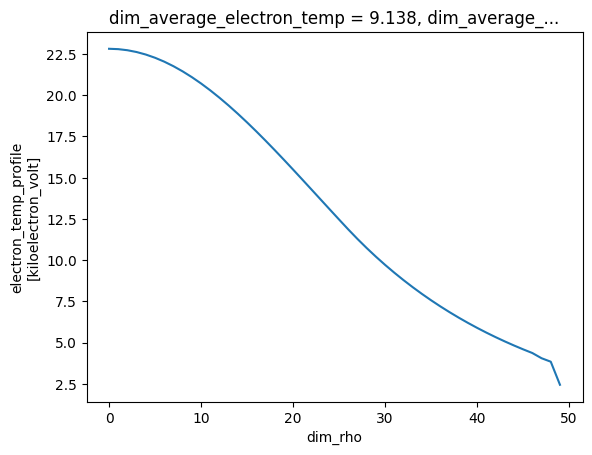

In [17]:
point.electron_temp_profile.pint.to(ureg.keV).plot()

That's the basics for using the POPCON library.

You can perform the analysis in this notebook using the command line tool. If you wanted to run this exact case from a terminal at the top-level of this repository, the command would be:
```
poetry run popcon example_cases/SPARC_PRD --show
```
where `example_cases/SPARC_PRD` is the path to the `input.yaml` file.

Feel free to try things out and change the `input.yaml` file. At some point, you'll probably want to dig into the formulas and algorithms and start implementing your own. For this, see the other notebooks in this folder.